# Goal Prediction in La Liga using Poisson Regression
by Iker Cámara Bengoechea.

The goal of this project is to collect and analyze football data with a focus on the Spanish football league: La Liga. Differently to other sports like basketball, scoring is scarce in football. The low-scoring nature of the game makes Poisson regression a good starting point to predict the scoring of football matches. Furthermore, we use a Poisson model to carry out a Monte Carlo simulation to predict the probability of each team to win the league before the last three gameweeks are played.

First, we import some well-known Python libraries that will be used in this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

To work with the Poisson distribution we import the `scipy.stats` library. Moreover, we use the `statsmodels` package to fit a Poisson regression model.

In [2]:
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Scraping Data from FBRef

In [3]:
from requests_html import HTMLSession
session = HTMLSession()

We are interested in the scores of every match of La Liga from the last five seasons. The data is scraped from FBref.com which is a stats site with world football data.

The scores are grouped in a HTML table so we can easily scrape them using the pandas function `read_html`. There are rows with all NaNs so we clean the data by removing them using the function `drop_na`. 

Every/each season data is in a different page but the urls do not follow a defined structure. For that reason, we move between the different pages using the 'Previous Season' buttom. We save the scraped data of a season in a list that is later concatenated in a single one. Additionally, a new column 'Season' is added to differentiate the seasons.

In [4]:
data = []
nSeasons = 5
# Start with current season
url = 'https://fbref.com/en/comps/12/schedule/La-Liga-Scores-and-Fixtures'
year = 2020

for _ in range(nSeasons):
    season_data = pd.read_html(url)[0]
    season_data = season_data.dropna(axis = 0, how = 'all') # Avoid rows with all NaNs
    season_data['Season'] = str(year) + '-' + str(year + 1) # Add season column
    data.append(season_data)
    # Get url from previous season using "Previous season" buttom
    r = session.get(url)
    html = r.html
    # Careful! You can get previous and next year
    urls = html.find('.prevnext')[0].absolute_links
    url = urls.pop()
    # Make sure previous season is taken
    if str(year) not in url:
        url = urls.pop()
    year = year - 1
LaLiga_df = pd.concat(data, ignore_index = True)

Next, we take a look of the collected data. For each match, we have the `Home` team and the `Away` team with the `Score`. Furthermore, other information is collected like the referee or the venue.

In [5]:
LaLiga_df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes,Season
0,1.0,Sat,2020-09-12,16:00,Eibar,0.4,0–0,0.9,Celta Vigo,NaN,Estadio Municipal de Ipurúa,Valentín Pizarro,Match Report,NaN,2020-2021
1,1.0,Sat,2020-09-12,18:30,Granada,0.3,2–0,0.9,Athletic Club,NaN,Estadio Nuevo Los Cármenes,Antonio Matéu Lahoz,Match Report,NaN,2020-2021
2,1.0,Sat,2020-09-12,21:00,Cádiz,1.1,0–2,0.9,Osasuna,NaN,Estadio Ramón de Carranza,Isidro Díaz de Mera,Match Report,NaN,2020-2021
3,1.0,Sun,2020-09-13,14:00,Alavés,1.0,0–1,0.6,Betis,NaN,Estadio de Mendizorroza,Pablo González,Match Report,NaN,2020-2021
4,1.0,Sun,2020-09-13,16:00,Valladolid,0.6,1–1,0.2,Real Sociedad,NaN,Estadio Municipal José Zorrilla,Mario Melero,Match Report,NaN,2020-2021


Next, we proceed to remove those columns that we will not use. For that, we use the function `drop`.

In [6]:
unnecessary_columns = ['Day', 'Time', 'xG', 'xG.1', 'Attendance', 'Venue', 'Referee', 'Match Report', 'Notes']
LaLiga_df = LaLiga_df.drop(unnecessary_columns, axis = 1)
LaLiga_df.head()

,Wk,Date,Home,Score,Away,Season
0,1.0,2020-09-12,Eibar,0–0,Celta Vigo,2020-2021
1,1.0,2020-09-12,Granada,2–0,Athletic Club,2020-2021
2,1.0,2020-09-12,Cádiz,0–2,Osasuna,2020-2021
3,1.0,2020-09-13,Alavés,0–1,Betis,2020-2021
4,1.0,2020-09-13,Valladolid,1–1,Real Sociedad,2020-2021


Lastly, we save the data in a .csv using the function `to_csv`. 

In [7]:
LaLiga_df.to_csv('LaLiga_data.csv', index = False)

## Checking Model Assumptions

In case the scraping failed, the data can be loaded using the following line:

In [8]:
LaLiga_df = pd.read_csv('LaLiga_data.csv')

The column `Score` is divided into two columns: `HomeGoals` and `AwayGoals`. To do that, we find all the numerical values in `Score` with `str.findall`by means of a regular expression.

In [9]:
LaLiga_df[['HomeGoals', 'AwayGoals']] = pd.DataFrame(LaLiga_df['Score'].str.findall("([0-9]+)").tolist(),
                                                     index = LaLiga_df.index)
LaLiga_df.head()

,Wk,Date,Home,Score,Away,Season,HomeGoals,AwayGoals
0,1.0,2020-09-12,Eibar,0–0,Celta Vigo,2020-2021,0,0
1,1.0,2020-09-12,Granada,2–0,Athletic Club,2020-2021,2,0
2,1.0,2020-09-12,Cádiz,0–2,Osasuna,2020-2021,0,2
3,1.0,2020-09-13,Alavés,0–1,Betis,2020-2021,0,1
4,1.0,2020-09-13,Valladolid,1–1,Real Sociedad,2020-2021,1,1


For further analysis we need to cast to integer the two new columns.

In [10]:
LaLiga_df['HomeGoals'] = LaLiga_df['HomeGoals'].astype(int)
LaLiga_df['AwayGoals'] = LaLiga_df['AwayGoals'].astype(int)

First, we check whether the assumption that the goals scored by a team can be modelled using a Poisson distribution. We compute the average number of goals that a team scores using the collected data and we differentiate between HomeTeam and AwayTeam.

In [11]:
LaLiga_df[['HomeGoals', 'AwayGoals']].mean()

HomeGoals    1.493684
AwayGoals    1.148421
dtype: float64

We assume that the goals scored by a team that plays at home can be modelled by a Poisson distribution with expected value 1.49. We compute the probability that the scores different number of goals using `poisson.pmf`. There is a 22.5% probability that the home team does not score any goals and a 33.5% probability that it scores 1 goal.

In [12]:
home_avg, away_avg = LaLiga_df[['HomeGoals', 'AwayGoals']].mean()
home_probs = [poisson.pmf(i, home_avg) for i in range(9)]
pd.DataFrame( {'Goals': range(9), 'Probability': home_probs}).style.hide_index()

Goals,Probability
0,0.224544
1,0.335398
2,0.250489
3,0.124717
4,0.046572
5,0.013913
6,0.003464
7,0.000739
8,0.000138


We do the same calculation for the away team. 

In [13]:
away_probs = [poisson.pmf(i, away_avg) for i in range(9)]
pd.DataFrame( {'Goals': range(9), 'Probability': away_probs}).style.hide_index()

Goals,Probability
0,0.317137
1,0.364207
2,0.209131
3,0.080057
4,0.022985
5,0.005279
6,0.001010
7,0.000166
8,0.000024


We compare the computed probabilities with real data and we observe that the fit is quite good. Therefore, the Poisson distribution seems to be a good approach to model goals in football.

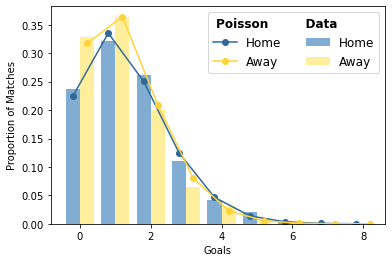

In [14]:
# Histogram with real data
LaLiga_hist = plt.hist(LaLiga_df[['HomeGoals', 'AwayGoals']].values, bins = range(9),
                       alpha = 0.7, align = 'left', density = True,
                       label = ['Home', 'Away'], color = ["#4B8BBE", "#FFE873"])

# Add lines for the Poisson distributions
poisHome, = plt.plot([i - 0.2 for i in range(9)], home_probs,
                     linestyle='-', marker='o', label = "Home", color = '#306998')
poisAway, = plt.plot([i + 0.2 for i in range(9)], away_probs,
                     linestyle='-', marker='o', label = "Away", color = '#FFD43B')
plt.xlabel("Goals")
plt.ylabel("Proportion of Matches")
leg = plt.legend(loc = 'upper right', fontsize=12, ncol=2)
leg.set_title("Poisson         Data        ", prop = {'size':'12', 'weight':'bold'})
plt.show()

Another assumption is that the goals scored by the two teams are independent. However, this is a strong assumption as we could expect different game strategies after scoring one goal or conceding one which might influence the final score.

If we assume that the goals scored by each team are independent we can compute the probability of a 1-1 score just by multiplying the probabilies of each team scoring one goal. In the same way, we calculate the probabilities of different scores of a football match. We can easily do that using `np.outer`.

In [15]:
scores_poisson = np.outer(home_probs, away_probs)
tab_poisson = pd.DataFrame(scores_poisson[0:5,0:5])
tab_poisson

,0,1,2,3,4
0,0.071211,0.081780,0.046959,0.017976,0.005161
1,0.106367,0.122154,0.070142,0.026851,0.007709
2,0.079439,0.091230,0.052385,0.020053,0.005757
3,0.039552,0.045423,0.026082,0.009984,0.002867
4,0.014770,0.016962,0.009740,0.003728,0.001070


Moreover, we compute the real frequencies using `pd.crosstab`. The most frequent result is 1-1 followed by 1-0. It is clear that football is scarce in goals as we see in the table that matches with more than 5 goals are rare. Besides, we also observe that the home team usually scores more goals. 

In [16]:
tab_real = pd.crosstab(index = LaLiga_df['HomeGoals'], columns = LaLiga_df['AwayGoals'])/len(LaLiga_df.index)
tab_real.iloc[0:5, 0:5]

AwayGoals,0,1,2,3,4
HomeGoals,,,,,
0,0.076842,0.080000,0.050000,0.018421,0.007368
1,0.105789,0.121053,0.059474,0.020526,0.011053
2,0.079474,0.100000,0.055263,0.015789,0.007895
3,0.040526,0.037368,0.021579,0.007368,0.002632
4,0.014737,0.015263,0.008421,0.002105,0.002105


By computing the difference we appreciate that the predicted frequencies are very close to the real ones. The error is less than 2% for all the scores. The times that the home team does not score any goals are slightly underestimated and the same happens when the away team scores a lot of goals. Furthermore, when using independent Poisson distributions the scores 3-1 and 1-2 are overestimated.

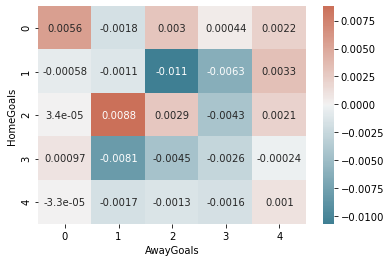

In [17]:
cm = sns.diverging_palette(220, 20, as_cmap = True)
diff = tab_real.iloc[0:5, 0:5] - tab_poisson
ax = sns.heatmap(diff, cmap=cm, center = 0.0, annot = diff)

In football as in other sports it is well-known the home advantage benefit. This is attributed to the presence of supporters who have a pshychological effect on the competitors and the referees and to other disadvantages as can be a different climate or the rigors of travel.

We explore this benefit in La Liga by computing the frequencies of home victories, draws and away victories. To do that, we create a new column `Result` with the result of the game using `np.select`.

In [18]:
conditions = [ LaLiga_df['HomeGoals'] > LaLiga_df['AwayGoals'],
               LaLiga_df['HomeGoals'] == LaLiga_df['AwayGoals'],
               LaLiga_df['HomeGoals'] < LaLiga_df['AwayGoals']
             ]
values = ['Home', 'Draw', 'Away']
LaLiga_df['Result'] = np.select(conditions, values)
LaLiga_df['Result'].value_counts(normalize = True)

Home    0.452632
Away    0.284737
Draw    0.262632
Name: Result, dtype: float64

Nevertheless, after the COVID-19 outbreak there are not supporters in the stadiums. Since 10th March 2020 all the matches in La Liga were played without crowd. Now, we explore whether this has had an effect in the home advantage. The number of home victories reduced from 46.6% to 41.4%.

In [19]:
post_covid = LaLiga_df[ LaLiga_df.Date > '2020-03-12']
post_covid['Result'].value_counts(normalize = True)

Home    0.414286
Away    0.302041
Draw    0.283673
Name: Result, dtype: float64

In [20]:
pre_covid = LaLiga_df[ LaLiga_df.Date < '2020-03-12']
pre_covid['Result'].value_counts(normalize = True)

Home    0.465957
Away    0.278723
Draw    0.255319
Name: Result, dtype: float64

In addition, the number of goals scored have been reduced specially for the home team.

In [21]:
post_covid[['HomeGoals','AwayGoals']].mean()

HomeGoals    1.344898
AwayGoals    1.124490
dtype: float64

In [22]:
pre_covid[['HomeGoals','AwayGoals']].mean()

HomeGoals    1.545390
AwayGoals    1.156738
dtype: float64

## Modelling

We fit a Poisson regression model to predict the number of goals a team $i$ will score against another team $j$ playing at home or away. In mathematical terms we can write this as
    $$ P(X_{i,j} = x) = \frac{e^{\lambda} \lambda^x}{x!} $$

where $\ln \lambda = \alpha_i T_i + \beta_j O_j + \gamma H$. In this equation, $T_i$ refers to the team $i$ whereas $O_j$ refers to the opponent team $j$. Therefore, $\alpha_i$ and $\beta_j$ denote the attack and defensive strength of each team. Moreover, we include $\gamma$ to include the home advantage factor which we assume is the same for all the teams. 

We consider data of the current season to only consider games without spectators.

In [23]:
LaLiga2021 = LaLiga_df.loc[ LaLiga_df['Season'] == '2020-2021']

Furthermore, we divide the dataset into two. We take the first 35 gameweeks to fit the model and we will predict the scores of the remaining matches.

In [24]:
LaLiga2021_Model = LaLiga2021.loc[ LaLiga2021['Wk'] < 36].copy()
LaLiga2021_Preds = LaLiga2021.loc[ LaLiga2021['Wk'] >= 36].copy()

We need to prepare the data to fit the model. In each row we indicate a team, its opponent, the number of goals scored by the team and whether that team played at home.

In [25]:
# Home team
LaLiga_Home = LaLiga2021_Model[['Home', 'Away', 'HomeGoals']].rename(
                        columns={'Home':'Team', 'Away':'Opponent', 'HomeGoals':'Goals'})
LaLiga_Home['Home'] = 1
# Away team
LaLiga_Away = LaLiga2021_Model[['Home', 'Away', 'AwayGoals']].rename(
                        columns={'Away':'Team', 'Home':'Opponent', 'AwayGoals':'Goals'})
LaLiga_Away['Home'] = 0
GoalModel_df = pd.concat([LaLiga_Home, LaLiga_Away])
GoalModel_df.head()

,Team,Opponent,Goals,Home
0,Eibar,Celta Vigo,0,1
1,Granada,Athletic Club,2,1
2,Cádiz,Osasuna,0,1
3,Alavés,Betis,0,1
4,Valladolid,Real Sociedad,1,1


Then, we fit the model using the `smf.glm` and `sm.families.Poisson()`. As output we obtain the $\alpha_i$ and $\beta_j$ for each team. We interpret this parameter as the relative attack and defensive strength of a team with respect to Alavés which is taken as the reference team. An $\alpha_i > 0$ implies that team $i$ scores in average more goals than Alavés. For example, against the same rival, we will expect that Real Madrid scores $e^{0.658} = 1.93$ times more goals. Contrarily, $\beta_j < 0$ indicates that a team is better defensively than Alavés as in average that team will receive fewer goals. Again, as  $e^{-0.682} = 0.51$ we can say that Real Madrid would concede half goals as Alavés against the same opponent.

From the $\alpha_i$ and $\beta_j$ we obtain that the best attacking team is Barcelona whereas the best defensive team is Atlético de Madrid.

Furthermore, we obtain a positive impact of the home advantage in the number of goals scored by a team. In average, a team playing at home will score $e^{0.173} = 1.19$ times more goals.

In [26]:
poisson_Model = smf.glm(formula = "Goals ~ Home + Team + Opponent", data = GoalModel_df, 
                        family = sm.families.Poisson()).fit()
poisson_Model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Goals   No. Observations:                  700
Model:                            GLM   Df Residuals:                      660
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -935.16
Date:                Thu, 10 Jun 2021   Deviance:                       673.81
Time:                        16:31:15   Pearson chi2:                     568.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0294      0.234     -0.126      0.900      -0.487       0.428
Team[T.Athletic Club]           0.3997      0.235      1.700      0.089      -0.061       0.861
Team[T.Atlético Madrid]         0.6667      0.224      2.982      0.003       0.229       1.105
Team[T.Barcelona]               0.9647      0.215      4.492      0.000       0.544       1.386
Team[T.Betis]                   0.4062      0.236      1.719      0.086      -0.057       0.869
Team[T.Celta Vigo]              0.5074      0.232      2.190      0.028       0.053       0.961
Team[T.Cádiz]                   0.0302      0.257      0.118      0.906      -0.473       0.533
Team[T.Eibar]                  -0.1142      0.266     -0.429      0.668      -0.635       0.407
Team[T.Elche]                  -0.0315      0.261     -0.121      0.904      -0.542       0.479
Team[T.Getafe]                 -0.1457      0.268     -0.543      0.587      -0.672       0.380
Team[T.Granada]                 0.3792      0.237      1.600      0.110      -0.085       0.844
Team[T.Huesca]                  0.0967      0.253      0.382      0.702      -0.399       0.592
Team[T.Levante]                 0.2788      0.242      1.151      0.250      -0.196       0.753
Team[T.Osasuna]                 0.0669      0.253      0.265      0.791      -0.429       0.562
Team[T.Real Madrid]             0.6580      0.224      2.937      0.003       0.219       1.097
Team[T.Real Sociedad]           0.5321      0.229      2.323      0.020       0.083       0.981
Team[T.Sevilla]                 0.5111      0.230      2.219      0.027       0.060       0.963
Team[T.Valencia]                0.4177      0.235      1.776      0.076      -0.043       0.879
Team[T.Valladolid]              0.0391      0.255      0.154      0.878      -0.460       0.538
Team[T.Villarreal]              0.5343      0.229      2.333      0.020       0.086       0.983
Opponent[T.Athletic Club]      -0.3356      0.212     -1.581      0.114      -0.752       0.080
Opponent[T.Atlético Madrid]    -0.8708      0.253     -3.436      0.001      -1.368      -0.374
Opponent[T.Barcelona]          -0.4322      0.222     -1.950      0.051      -0.867       0.002
Opponent[T.Betis]              -0.1273      0.200     -0.636      0.525      -0.519       0.265
Opponent[T.Celta Vigo]          0.0242      0.194      0.125      0.901      -0.356       0.405
Opponent[T.Cádiz]              -0.0898      0.197     -0.456      0.648      -0.475       0.296
Opponent[T.Eibar]              -0.1404      0.201     -0.698      0.485      -0.535       0.254
Opponent[T.Elche]              -0.0546      0.195     -0.281      0.779      -0.436       0.327
Opponent[T.Getafe]             -0.2729      0.208     -1.315      0.189      -0.680       0.134
Opponent[T.

The previous model provides the average number of goals a team will score against another given team. If we assume that the goals scored by each team are independent we can use the model to compute the probabilities of the score of a football match. In mathematical terms

$$ P(X = x, Y = y) = \frac{e^{\lambda} \lambda^x}{x!} \frac{e^{\mu} \mu^y}{y!} $$

with $\ln \lambda = \alpha_X X + \beta_Y Y + \gamma$ and $\ln \mu = \alpha_Y Y + \beta_X X $.

With that, we write the function `probsMatch`.

In [27]:
def probsMatch(HomeTeam, AwayTeam):
    mu_Home = poisson_Model.predict( pd.DataFrame( data={'Team': HomeTeam, 'Opponent': AwayTeam, 'Home': 1}, index = [1]))
    mu_Away = poisson_Model.predict( pd.DataFrame( data={'Team': AwayTeam, 'Opponent': HomeTeam, 'Home': 0}, index = [1]))
    home_probs = [poisson.pmf(i, mu_Home) for i in range(5)]
    away_probs = [poisson.pmf(i, mu_Away) for i in range(5)]
    return pd.DataFrame(np.outer(home_probs, away_probs))

As an example, we compute the probabilities of different scores if Real Madrid and Barcelona played a match. The most probable score is 1-1.

In [28]:
probsMatch('Real Madrid', 'Barcelona')

,0,1,2,3,4
0,0.064837,0.083535,0.053812,0.023110,0.007444
1,0.093852,0.120917,0.077893,0.033452,0.010775
2,0.067926,0.087513,0.056375,0.024211,0.007798
3,0.032774,0.042225,0.027201,0.011682,0.003763
4,0.011860,0.015280,0.009843,0.004227,0.001362


Furthermore, we can simulate the matches. We just need to randomly sample from a Poisson distribution using `poisson.rvs` with parameter the output of the model.

In [29]:
def simulateMatch(HomeTeam, AwayTeam):
    mu_Home = poisson_Model.predict( pd.DataFrame( data={'Team': HomeTeam, 'Opponent': AwayTeam, 'Home': 1}, index = [1]))
    mu_Away = poisson_Model.predict( pd.DataFrame( data={'Team': AwayTeam, 'Opponent': HomeTeam, 'Home': 0}, index = [1]))
    HomeGoals = poisson.rvs(mu_Home)
    AwayGoals = poisson.rvs(mu_Away)
    return str(HomeGoals) + '-' + str(AwayGoals)

In [30]:
simulateMatch('Real Madrid', 'Barcelona')

'1-1'

With the last function we can proceed to simulate the remaining matches of this season. But first, the real results are removed

In [31]:
LaLiga2021_Preds = LaLiga2021_Preds.drop(['Score', 'HomeGoals', 'AwayGoals', 'Result'], axis = 1)

We use the function `simulateMatch` to simulate the last three gameweeks.

In [32]:
LaLiga2021_Preds['Score'] = LaLiga2021_Preds.apply(lambda x: simulateMatch(x.Home, x.Away), axis = 1)
LaLiga2021_Preds[['HomeGoals', 'AwayGoals']] = pd.DataFrame(LaLiga2021_Preds.loc[:,'Score'].str.findall("([0-9]+)").tolist(),
                                                            index = LaLiga2021_Preds.index)
LaLiga2021_Preds['HomeGoals'] = LaLiga2021_Preds['HomeGoals'].astype(int)
LaLiga2021_Preds['AwayGoals'] = LaLiga2021_Preds['AwayGoals'].astype(int)

Moreover, we need to delete the column `Result`to concatenate the two dataframes.

In [33]:
LaLiga2021_Model = LaLiga2021_Model.drop(['Result'], axis = 1)
LaLiga_sim = pd.concat([LaLiga2021_Model, LaLiga2021_Preds])

Once the remaining matches of the season are simulated we can compute the final league table. For that, we create a function that takes all the matches and creates a new dataframe like the one we used to fit the model but now we also include the goals scored by the opponent. Moreover, we create a new column indicating the number of points that a team obtained in that match. The procedure to get that column is the same as we did before to include the column `Result` but this time we call it `Points` with values 3, 1, 0 depending if the team won, drew or lost respectively. Then, we just need to do a `groupby` to add up the number of points and the goals scored and conceded. Finally, we just order the table in descending order of `Points`.

In [34]:
def compute_table(league):
    # Modify dataframe with one row per team and match
    league_home = league[['Home', 'HomeGoals', 'AwayGoals']].rename(columns={'Home':'Team', 'HomeGoals':'GF', 'AwayGoals':'GA'})
    league_away = league[['Away', 'AwayGoals', 'HomeGoals']].rename(columns={'Away':'Team', 'AwayGoals':'GF', 'HomeGoals':'GA'})
    league_goals = pd.concat([league_home, league_away])
    # Add column with number of points earned in that game
    points_cond = [ league_goals['GF'] > league_goals['GA'],
                    league_goals['GF'] == league_goals['GA'],
                    league_goals['GF'] < league_goals['GA'] ]
    points = [3, 1, 0]
    league_goals['Points'] = np.select(points_cond, points)
    # Compute sum of points and goals for and against
    table = league_goals.groupby(['Team']).sum()
    # Compute goal difference
    table['GD'] = table['GF'] - table['GA']
    table['Team'] = table.index
    # Check whether some teams have the same number of points
    if len(table['Points'].unique()) < len(table.index):
        return tiebreaker(table, league)
    # Order of columns in output table
    column_order = ['Team', 'Points', 'GF', 'GA', 'GD']
    table = table.loc[:,column_order]
    # Sort in descending number of points
    table =  table.sort_values(by = 'Points', ascending = False).reset_index(drop = True)
    return table

It is possible that two teams get the same number of points. In that case, we need to break the tie following the rules imposed by La Liga. This is important because it can decide the winner or the relegated teams. If two teams finalize the league with the same number of points, we look at the head to head between them. This is, the team that scored more goals in the games among them goes first. In the case the same number of goals were scored, the team with a larger goal difference is on top. If more than two teams have the same number of points, we order the teams according to the table resulting of considering only matches with those teams. For this second case, we call the previous function to compute the reduced table.

We create a temporary column `untie` that allows us to order those teams with the same number of points. We assign a higher value in this column to those teams that should go on top in the league table. By doing that, we can just `sort_values` by `Points` and the new column.

In [35]:
def tiebreaker(table, league):
    # Create temporary columnd
    table['untie'] = 0
    # Get number of ties
    point_count = table['Points'].value_counts()
    points_draw = point_count[ point_count > 1 ].index
    # Loop for every tie
    for p in points_draw:
        # Teams with same number of points
        df = table[table['Points'] == p].copy()
        teams = df['Team'].unique()
        if len(teams) == 2: # Tie with only 2 teams --> check head to head
            # Take only games with the two teams
            matches_filter = (league['Home'].isin(teams)) & (league['Away'].isin(teams))
            matches = league[matches_filter].reset_index(drop = True)
            # TeamA first plays at home and the second game away
            teamA = matches.loc[0, 'Home']
            teamA_goals = matches.loc[0, 'HomeGoals'] + matches.loc[1, 'AwayGoals']
            # TeamB first plays away and the second at home
            teamB = matches.loc[0, 'Away']
            teamB_goals = matches.loc[0, 'AwayGoals'] + matches.loc[1, 'HomeGoals']
            if teamA_goals > teamB_goals: # TEAM A WINS H2H
                table.loc[table['Team'] == teamA, 'untie'] = 1
            elif teamB_goals > teamA_goals:
                table.loc[table['Team'] == teamB, 'untie'] = 1
            else: # Same number of goals --> check GD
                if table.loc[table['Team'] == teamA, 'GD'].values[0] > table.loc[table['Team'] == teamB, 'GD'].values[0]:
                    table.loc[table['Team'] == teamA, 'untie'] = 1
                else:
                    table.loc[table['Team'] == teamB, 'untie'] = 1  
        else: # Tie with more than 2 teams --> check particular table
            # Take only games with the involved teams
            matches_filter = (league['Home'].isin(teams)) & (league['Away'].isin(teams))
            matches = league[matches_filter].reset_index(drop = True)
            # Compute new table
            table_small = compute_table(matches)
            # Assign untie value in inverse order than position
            table_small['untie'] = -(-len(teams) + table_small.index)
            table_small = table_small.set_index('Team')
            # Update untie column in initial table. (We use as index the team name)
            table.update( table_small['untie'] )
    final_table = table.sort_values(by = ['Points', 'untie'], ascending = False).reset_index(drop = True)
    column_order = ['Team', 'Points', 'GF', 'GA', 'GD']
    return final_table[column_order]

The simulated final table of La Liga 2020/21 is:

In [36]:
compute_table(LaLiga_sim)

,Team,Points,GF,GA,GD
0,Atlético Madrid,82,64,24,40
1,Barcelona,82,87,36,51
2,Real Madrid,81,63,27,36
3,Sevilla,78,56,32,24
4,Real Sociedad,60,56,37,19
5,Betis,58,49,49,0
6,Villarreal,56,54,43,11
7,Athletic Club,50,49,40,9
8,Celta Vigo,49,52,58,-6
9,Granada,49,46,60,-14


# Monte Carlo Simulation

Finally, we use the Poisson model to run a Monte Carlo simulation that generates a distribution of the final position of each team in LaLiga. 

For that, we just code a function `MonteCarloSimulation` that wraps up the steps that we took before to simulate the remaining matches of the season. Then, it repeats this procedure a large number of times to get estimates of the probability distribution.

In [37]:
def MonteCarloSimulation(nSimulations, matches, matches_played):
    # Create dataframe to store results
    mat = np.zeros((20,20), dtype = int)
    combined_results = pd.DataFrame(mat, index = matches['Home'].unique(), columns = range(1,21))
    # Loop to run the simulations
    for _ in range(nSimulations):
        # Simulate remaining matches
        matches['Score'] = matches.apply(lambda x: simulateMatch(x.Home, x.Away), axis = 1)
        league = pd.concat([matches_played, matches])
        league[['HomeGoals', 'AwayGoals']] = pd.DataFrame(league.loc[:,'Score'].str.findall("([0-9]+)").tolist(),
                                                          index = league.index)
        league = league.drop(['Score'], axis = 1)
        league['HomeGoals'] = league['HomeGoals'].astype(int)
        league['AwayGoals'] = league['AwayGoals'].astype(int)
        table = compute_table(league)
        # Add simulation results to the dataframe
        for index, row in table.iterrows():
            combined_results.loc[row['Team'], index + 1] += 1
        # Delete simulated results before running a new simulation
        matches = matches.drop(['Score'], axis = 1)
    # Order in descending order of final position and normalize to get probabilities
    combined_results = combined_results.sort_values(combined_results.columns.tolist(), ascending = False)/nSimulations
    return combined_results

The data we need to use as input are two dataframes, one with the played matches and the other one with the matches that we want to simulate. The former dataframe should not have the `Score` column.

In [38]:
matches_played = LaLiga2021.loc[ LaLiga2021['Wk'] < 36].copy()
matches = LaLiga2021.loc[ LaLiga2021['Wk'] >= 36].copy()
matches = matches.drop('Score', axis = 1)

After running the simulation, we obtain some interesting results. Regarding the title fight, Atlético de Madrid is the most probable winner with a 65% probability of lifting the trophy. The other two main contenders, Real Madrid and Barcelona, have 19% and 16% probabilities respectively of finishing on top. The fourth team with mathematical options to win the league is Sevilla but our simulation gives them a really small change of winning it. 

On the relegation side, the three bottom teams of the table, Eibar has a high probability of 87% of playing in the second division next year. Moreover, the other teams fighting to avoid being relegated are Valladolid with a 67% probability, Huesca with a 57% probability, Elche with a 50% probability and Alavés with a 30% probability. In addition, the options of Getafe of being relegated are very low, only 2%.

Note: the simulation takes almost an hour to run.

In [39]:
nSimulations = 10000
tab = MonteCarloSimulation(nSimulations, matches, matches_played)
# Output only with 2 decimals
pd.set_option('precision', 2)
# Define color palette
cm = sns.light_palette("red", as_cmap = True)
tab.style.background_gradient(cmap = cm)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Atlético Madrid,0.65,0.23,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Real Madrid,0.19,0.31,0.43,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Barcelona,0.16,0.45,0.37,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Sevilla,0.00,0.01,0.09,0.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Real Sociedad,0.00,0.00,0.00,0.00,0.77,0.21,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Betis,0.00,0.00,0.00,0.00,0.21,0.65,0.13,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Villarreal,0.00,0.00,0.00,0.00,0.02,0.13,0.76,0.08,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Celta Vigo,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.47,0.32,0.14,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Athletic Club,0.00,0.00,0.00,0.00,0.00,0.00,0.05,0.30,0.35,0.23,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Granada,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.12,0.23,0.33,0.24,0.06,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00


We can compare the simulated results with the real final table of La Liga 2020/21. We observe that the final positions go in line with the probabilities predicted by our model. There are not big surprises. Atlético finally won La Liga followed by Real Madrid and Barcelona. Moreover, the relegated teams were Huesca, Valladolid and Eibar which were the teams with highest predicted probabilities of being relegated.

In [50]:
compute_table(LaLiga2021)

,Team,Points,GF,GA,GD
0,Atlético Madrid,86,67,25,42
1,Real Madrid,84,67,28,39
2,Barcelona,79,85,38,47
3,Sevilla,77,53,33,20
4,Real Sociedad,62,59,38,21
5,Betis,61,50,50,0
6,Villarreal,58,60,44,16
7,Celta Vigo,53,55,57,-2
8,Granada,46,47,65,-18
9,Athletic Club,46,46,42,4


## Conclusion

With Poisson regression we were able to fit a model to prefict football scores. In addition, with this model we are able to analyze attack and defensive strengths of La Liga teams and quantify the effect of the home advantage. Nevertheless, the model presents some limitations as matches played eight months ago have the same weight than matches recently played in the estimation of the parameters of the model.

Furthermore, a Monte Carlo simulation was carried out to obtain a probability distribution of the final position of each team. This is a common technique in many fields such as finance or engineering that was succesfully applied in this project. The predicted probabilities were in line with the real outcome of La Liga 2020/21 so we are satisfied with the performance of our model.